In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


In [ ]:
class MarketDataset(Dataset):
    def __init__(self, features, targets, sequence_length=60):
        self.features=torch.tensor(features, dtype=torch.float32)
        self.targets=torch.tensor(targets, dtype=torch.float32)
        self.seq_len=sequence_length

    def __len__(self):
        return len(self.features)-self.seq_len

    def __getitem__(self, idx):
        x = self.features[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return x, y


In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        num_layers,
        output_dim=1,
        dropout=0.2
    ):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim=hidden_dim
        self.num_layers=num_layers

        self.lstm=nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc=nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0=torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0=torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _= self.lstm(x, (h0, c0))

        out=out[:, -1, :]
        prediction=self.fc(out)

        return prediction


In [19]:
INPUT_DIM=7     
HIDDEN_DIM=64
NUM_LAYERS=2
SEQ_LEN=60

BATCH_SIZE=32
LR=0.001
EPOCHS=50

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [20]:
# Random data for illustration
N = 1200
features=np.random.randn(N, INPUT_DIM)
targets=np.random.randn(N)

train_size=1000

train_features=features[:train_size]
test_features=features[train_size:]

train_targets=targets[:train_size]
test_targets=targets[train_size:]


In [22]:
train_dataset=MarketDataset(
    train_features,
    train_targets,
    sequence_length=SEQ_LEN
)

test_dataset=MarketDataset(
    test_features,
    test_targets,
    sequence_length=SEQ_LEN
)

train_loader=DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

test_loader=DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)


In [23]:
model=SentimentLSTM(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
).to(device)

criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=LR)


In [24]:
model.train()

for epoch in range(EPOCHS):
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs=model(X_batch)

        loss=criterion(outputs.squeeze(-1), y_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss+=loss.item()

    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.6f}")


Starting training...
Epoch 10/50, Loss: 0.931258
Epoch 20/50, Loss: 0.784726
Epoch 30/50, Loss: 0.687764
Epoch 40/50, Loss: 0.568120
Epoch 50/50, Loss: 0.388384


In [25]:
model.eval()
predictions=[]
actuals=[]

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch=X_batch.to(device)
        output=model(X_batch)

        predictions.append(output.item())
        actuals.append(y_batch.item())


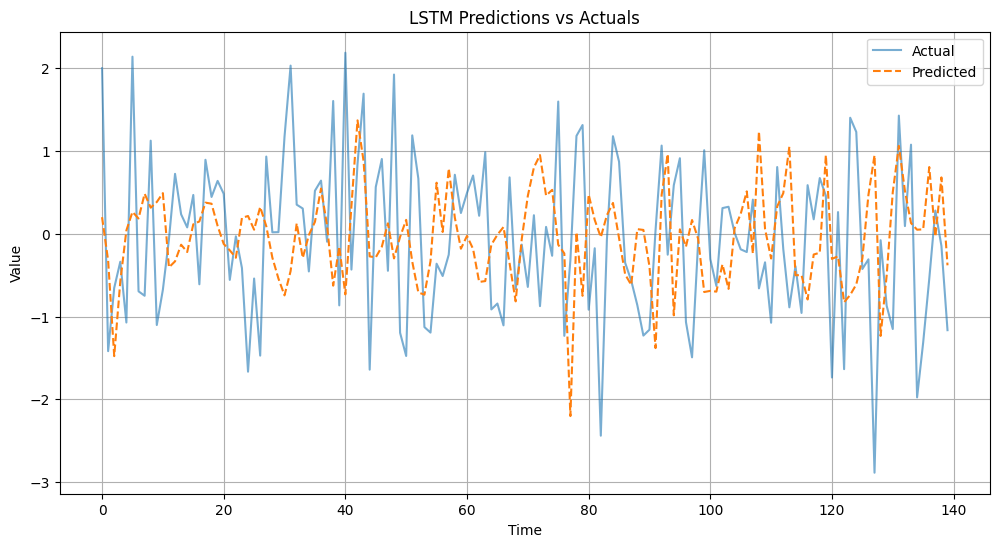

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", alpha=0.6)
plt.plot(predictions, label="Predicted", linestyle="--")
plt.title("LSTM Predictions vs Actuals")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
torch.save(model.state_dict(), "lstm.pt")
